# Recommender System



## Content-Based  Movie recommendation system

### Objective

Our objective is to build a movie recommendation system based on content.
Content based recommendation system works on the principal of similar items

### Recommender system 
Capture the pattern of people's behaviour and use it to predict what else they might want or like. i.e Show me more of the same of what I've liked for.
Recommendation systems are a collection of algorithms used to recommend items to users based on information taken from the user.

## Required Libraries

In [1]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Acquiring the Data

Data is from the IBM Object Storage.

In [2]:
#Storing the movie information into a pandas dataframe
movies_df = pd.read_csv('movies.csv')
#Storing the user information into a pandas dataframe
ratings_df = pd.read_csv('ratings.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Preprocessing

Let's also remove the year from the title column by using pandas' replace function and store in a new year column.

In [3]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '',regex=True)
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


With that, let's also split the values in the Genres column into a list of Genres to simplify for future use. This can be achieved by applying Python's split string function on the correct column.

In [4]:
#Every genre is separated by a | so calling the split function on |
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


## One Hot Handling

Using  the One Hot Encoding technique to convert the list of genres to a vector where each column corresponds to one possible value of the feature.
This encoding is needed for feeding categorical data. In this case, we store every different genre in columns that contain either 1 or 0. 
- 1 shows that a movie has that genre and
- 0 shows that it doesn't. 
Let's also store this dataframe in another variable since genres won't be important for our first recommendation system.


In [5]:
#Copying the movie dataframe into a new one 
moviesWithGenres_df = movies_df.copy()

#iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
#Filling in the NaN values with 0 
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, let's look at the ratings dataframe.


In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


 We won't be needing the timestamp column, so let's drop it to save memory.

In [7]:
#Drop removes a specified row or column from a dataframe
ratings_df = ratings_df.drop(columns='timestamp',axis= 1)
ratings_df.head()

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


# Modeling - Content Based  Recommendation System

### Steps
- Taking input from User
- Weighting the genres
- Multiply user input rating to genre to get weighted genre table
- taking Average of genre
- Shaping profile of user according to genres
- Normalizing data
- Multiply user profile with movies matrix 
- Taking weighted of movies 
- Summing for obtaining Weighted average for each movie 
- Recommendation Table is ready






### How to add new movies 
To add more movies, simply increase the amount of elements in the userInput. Feel free to add more in! Just be sure to write it in with capital letters and if a movie starts with a "The", like "The Matrix" then write it in like this: 'Matrix, The' .

Let's begin by creating an input user to recommend movies to:


In [8]:
userInput = [
            {'title':'Dune', 'rating':3},
            {'title':'Lord of the Rings ,The','rating':4},
            {'title':'Jumanji', 'rating':3},
            {'title':'Who Framed Roger Rabbit?', 'rating':4.5},
            {'title':'Osmosis Jones', 'rating':3.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,Dune,3.0
1,"Lord of the Rings ,The",4.0
2,Jumanji,3.0
3,Who Framed Roger Rabbit?,4.5
4,Osmosis Jones,3.5


## Plot Graph

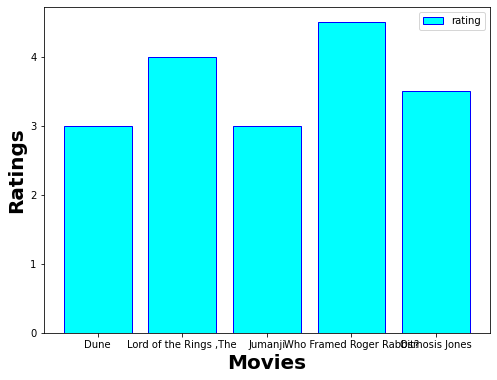

In [9]:
import matplotlib.pyplot as plt
import numpy as np
df= pd.DataFrame(inputMovies)
name= df['title']
rating= df['rating']

fig=plt.figure(figsize=(8,6))
plt.bar(name,rating, color='aqua', edgecolor= "blue", label= 'rating')
plt.xlabel('Movies', fontweight='bold',fontsize=20)
plt.ylabel('Ratings', fontweight= 'bold', fontsize=20)
plt.legend()
plt.show()

Add movieId to input user
Extracting the input movie's ID's from the movies dataframe and add them into it.

We can achieve this by first filtering out the rows that contain the input movie's title and then merging this subset with the input dataframe. We also drop unnecessary columns for the input to save memory space.

In [10]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. 
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we don't need
inputMovies = inputMovies.drop(columns='genres',axis= 1).drop(columns='year',axis= 1)
inputMovies

,movieId,title,rating
0,2,Jumanji,3.0
1,2021,Dune,3.0
2,7842,Dune,3.0
3,2987,Who Framed Roger Rabbit?,4.5
4,4719,Osmosis Jones,3.5


Get the subset of movies that the input has watched from the Dataframe containing genres defined with binary values.

In [11]:
#Filtering out the movies
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1938,2021,Dune,"[Adventure, Sci-Fi]",1984,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2902,2987,Who Framed Roger Rabbit?,"[Adventure, Animation, Children, Comedy, Crime...",1988,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4625,4719,Osmosis Jones,"[Action, Animation, Comedy, Crime, Drama, Roma...",2001,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7518,7842,Dune,"[Drama, Fantasy, Sci-Fi]",2000,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We'll only need the actual genre table, so let's clean this up a bit by resetting the index and dropping the movieId, title, genres and year columns.

In [12]:
#Resetting the index
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop(columns='movieId',axis= 1).drop(columns='title',axis= 1).drop(columns='genres',axis= 1).drop(columns='year',axis= 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Start learning the input's preferences!

- Turning each genre into weights.
- Multiplying input's reviews into the input's genre table and then 
- summing up the resulting table by column. (This operation is actually a dot product between a matrix and a vector, so we can simply accomplish by calling the Pandas "dot" function)


In [13]:
inputMovies['rating']

0    3.0
1    3.0
2    3.0
3    4.5
4    3.5
Name: rating, dtype: float64

In [14]:
#Dot produt
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             9.0
Animation             7.5
Children              6.0
Comedy                7.5
Fantasy               9.5
Romance               4.5
Drama                 8.0
Action                4.5
Crime                 7.5
Thriller              4.5
Horror                0.0
Mystery               3.0
Sci-Fi                6.5
IMAX                  0.0
Documentary           0.0
War                   0.0
Musical               0.0
Western               0.0
Film-Noir             0.0
(no genres listed)    0.0
dtype: float64

Let's start by extracting the genre table from the original dataframe:

In [21]:
#Now let's get the genres of every movie
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
#Dropping Columns not needed
genreTable = genreTable.drop(columns='movieId', axis=1).drop(columns='title', axis=1).drop(columns='genres',axis= 1).drop(columns='year',axis= 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


lets see number of rows and columns

In [16]:
genreTable.shape

(34208, 20)

Now we have input profile, lets take the average of every movie based on their input profile to make recommendation table



### Steps 
Multiply the genres by the weights and then take the weighted average


In [17]:
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.506410
2    0.314103
3    0.153846
4    0.256410
5    0.096154
dtype: float64

In [18]:
#Sort our recommendations in descending order
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
#lets take a look at some values
recommendationTable_df.head()

movieId
5018      0.711538
26093     0.666667
27344     0.647436
2987      0.641026
146305    0.634615
dtype: float64

# Final Recommendation Table

Now we have recommendation table which user will prefer

In [19]:
movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(20).keys())]

,movieId,title,genres,year
664,673,Space Jam,"[Adventure, Animation, Children, Comedy, Fanta...",1996
2902,2987,Who Framed Roger Rabbit?,"[Adventure, Animation, Children, Comedy, Crime...",1988
4212,4306,Shrek,"[Adventure, Animation, Children, Comedy, Fanta...",2001
4625,4719,Osmosis Jones,"[Action, Animation, Comedy, Crime, Drama, Roma...",2001
4923,5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
6793,6902,Interstate 60,"[Adventure, Comedy, Drama, Fantasy, Mystery, S...",2002
8605,26093,"Wonderful World of the Brothers Grimm, The","[Adventure, Animation, Children, Comedy, Drama...",1962
9296,27344,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999
9825,32031,Robots,"[Adventure, Animation, Children, Comedy, Fanta...",2005
11230,47404,Mind Game,"[Adventure, Animation, Comedy, Fantasy, Romanc...",2004
